In [1]:
import numpy as np
import pandas as pd

from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import pickle

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from num2words import num2words
from collections import Counter
from scipy import spatial
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from scipy.special import gammaln
from collections import Counter
from textblob import TextBlob
import scipy
import operator
import nltk
import os
import string
import numpy as np
import copy
import pandas as pd
import pickle

In [49]:
def coherence_score(X, topic_sentiment_df):
    X[X>1] = 1    
    totalcnt = len(topic_sentiment_df)
    total = 0
    for allwords in topic_sentiment_df:
        for word1 in allwords:
            for word2 in allwords:
                if word1 != word2:
                    ind1 = vocab.index(word1)
                    ind2 = vocab.index(word2)
                    total += np.log((np.matmul(X[:,ind1].T, X[:,ind2]) + 1.0)/np.sum(X[:,ind2]))
    return total/(2*totalcnt)

def kl_score(pk,qk):
    return (scipy.stats.entropy(pk,qk)*.5 + scipy.stats.entropy(qk,pk)*.5)

def get_hscore(dt_distribution, x):
    testlen = X.shape[0]
    all_kl_scores = np.zeros((testlen, testlen))
    for i in range(testlen-1):
        for j in range(i+1,testlen):
            score = kl_score(dt_distribution[i],dt_distribution[j])
            all_kl_scores[i,j] = score
            all_kl_scores[j,i] = score

    dt = np.zeros((X.shape[0], k))

    for i in range(X.shape[0]):
        dt[i, dt_distribution[i].argmax()]=1

    intradist = 0
    for i in range(k):
       cnt = dt[:,i].sum()
       tmp = np.outer(dt[:,i],dt[:,i])
       tmp = tmp * all_kl_scores
       intradist += tmp.sum()*1.0/(cnt*(cnt-1))
    intradist = intradist/k

    interdist = 0
    for i in range(k):
       for j in range(k):
           if i != j:
             cnt_i = dt[:,i].sum()
             cnt_j = dt[:,j].sum()
             tmp = np.outer(dt[:,i], dt[:,j])
             tmp = tmp * all_kl_scores
             interdist += tmp.sum()*1.0/(cnt_i*cnt_j)
    interdist = interdist/(k*(k-1))
    return intradist/interdist

def plot_TSNE(dt_distribution):
    X_embedded = TSNE(n_components=2).fit_transform(dt_distribution)

    X = np.array([i[0] for i in X_embedded])
    Y = np.array([i[1] for i in X_embedded])
    C = dt_distribution.argmax(axis=1)
    for i in range(10):
        xx = X[[np.where(C == i)[0].tolist()]]
        yy = Y[[np.where(C == i)[0].tolist()]]
        plt.scatter(xx, yy, label=str(i))

    plt.title('Document-Topic Distribution')
    plt.legend(loc=(1.04,0))
    plt.show()
    
def get_doc_details(num):
    print("label: ", C[num])
    print(dataset[9][num])

In [24]:
icd_words = pickle.load(open("unique_words.pickle",'rb'))

In [25]:
dataset = pd.read_pickle("dataset_cleaned_autocorrected")

In [26]:
dataset[8] = dataset[7].apply(lambda x: [item for item in x.split(" ") if item in icd_words])
dataset[9] = dataset[8].apply(lambda x: " ".join(x))

In [28]:
data = dataset[9].values
vectorizer = CountVectorizer()
_X = vectorizer.fit_transform(data)
vocab = vectorizer.get_feature_names()
X = _X.todense()

In [29]:
k = 10
n_top_words = 5

In [30]:
model = LatentDirichletAllocation(n_topics=k, random_state=100)

In [31]:
id_topic = model.fit_transform(X)

/root/miniconda3/envs/python2/lib/python2.7/site-packages/sklearn/decomposition/online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


In [32]:
topic_words = {}
for topic, comp in enumerate(model.components_):
    word_idx = np.argsort(comp)[::-1][:n_top_words]
    topic_words[topic] = [vocab[i] for i in word_idx]

In [34]:
sample_df = []
for topic, words in topic_words.items():
    sample_df.append(', '.join(words).split(", "))

In [40]:
dt_distribution = model.transform(X)
C = dt_distribution.argmax(axis=1)

In [36]:
get_hscore(dt_distribution, X)

0.058791395179365456

In [37]:
coherence_score(X, sample_df)

matrix([[-10.58100208]])

/root/miniconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:58: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/root/miniconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:59: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


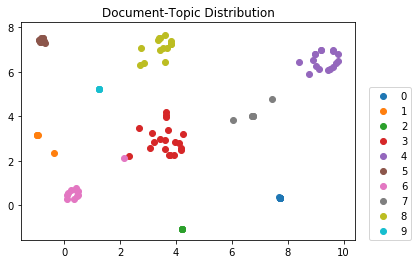

In [38]:
plot_TSNE(dt_distribution)

In [39]:
sample_df

[[u'war', u'radiotherapy', u'cell', u'lap', u'diet'],
 [u'carcinoma', u'bilateral', u'cancer', u'node', u'neck'],
 [u'crime', u'renal', u'drop', u'lower', u'respiratory'],
 [u'sudden', u'cycle', u'chemotherapy', u'life', u'consciousness'],
 [u'coronary', u'proximal', u'disease', u'dominant', u'knee'],
 [u'cell', u'count', u'respiratory', u'charge', u'sepsis'],
 [u'war', u'baby', u'valve', u'neck', u'stop'],
 [u'coronary', u'cell', u'wall', u'absent', u'containing'],
 [u'visit', u'surgical', u'drop', u'category', u'status'],
 [u'drop', u'arch', u'central', u'radiotherapy', u'carcinoma']]

In [48]:
get_doc_details(10)

('label: ', 3)
cycle cycle ant chemotherapy free club diabetic


In [55]:
print(dataset[9][0])

multi trauma center cerebrovascular accident new fibula acute hemiplegia due parietal lobe weakness body slurred speech unable associated headache reason feeling letter special fixed property three multi
